In [2]:
# import os

# # Define the directories

# for gauge_num in range(0,10):
#     dir1 = f"/nfs/a161/gy17m2a/PhD/ProcessedData/IndependentEvents/UKCP18_30mins/bc006/{gauge_num}/WholeYear/"
#     dir2 = f"/nfs/a161/gy17m2a/PhD/ProcessedData/IndependentEvents/UKCP18_30mins/Present/bc006/{gauge_num}/WholeYear/"

#     # Get filenames in each directory
#     files_dir1 = set(os.listdir(dir1))
#     files_dir2 = set(os.listdir(dir2))

#     # Find files in dir1 but not in dir2
#     only_in_dir1 = files_dir1 - files_dir2

#     # Find files in dir2 but not in dir1
#     only_in_dir2 = files_dir2 - files_dir1

#     # Print results
#     if only_in_dir1:
#         print("Files in directory 1 but not in directory 2:")
#         for file in only_in_dir1:
#             print(file)
#     else:
#         print("No files unique to directory 1.")

#     if only_in_dir2:
#         print("\nFiles in directory 2 but not in directory 1:")
#         for file in only_in_dir2:
#             print(file)
#     else:
#         print("No files unique to directory 2.")


In [3]:
import os
import numpy as np
import re
import pickle
import sys
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
# import datetime 
from datetime import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
import json
from statsmodels.graphics.mosaicplot import mosaic
from scipy.stats import gaussian_kde, linregress
from scipy import stats
import matplotlib.patches as mpatches


sys.path.insert(1, '../')
# from SeasonalPlot_Functions import *

from MasterPlot_Functions import *
from FormatEvents_Functions import *

import cmasher as cmr
import matplotlib as mpl

# Access rainforest colormap through CMasher or MPL
cmap = cmr.rainforest                   
cmap = mpl.colormaps['cmr.seaweed']  

In [4]:
home_dir = '/nfs/a319/gy17m2a/PhD/'
home_dir2 = '/nfs/a161/gy17m2a/PhD/'

In [5]:
tbo_vals = pd.read_csv(home_dir + 'datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')
tbo_vals = tbo_vals[tbo_vals['Lon']!=-999.0]
tbo_vals['gauge_num'] = tbo_vals.index

### Load and prepare data

#### All events data

In [6]:
df_long = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/all_events_characteristics_new.csv")
df_long['dur_for_which_this_is_amax'] = df_long['dur_for_which_this_is_amax'].apply(json.loads)
# df_long = df_long[~df_long['filename'].str.contains("part1", case=False)]
present_all_events=df_long[df_long['Climate']=='Present'].copy()
future_all_events =df_long[df_long['Climate']=='Future'].copy()
# nimrod = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/NIMROD_30mins/all_events_characteristics.csv")

In [7]:
print(len(present_all_events))
print(len(future_all_events))

1034950
1020443


In [8]:
# duration=24
# future_data = future_all_events
# future_duration_data = future_data[future_data["dur_for_which_this_is_amax"].apply(
#     lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]

# home_dir2 = '/nfs/a161/gy17m2a/PhD/'
# indy_events_fp = home_dir2 + f"ProcessedData/IndependentEvents/UKCP18_30mins/Future/bb211/418/WholeYear/EventSet/"
# sample1 = pd.read_csv(indy_events_fp + "24hrs_2073_v2_part1.csv")['precipitation (mm)']
# plt.plot(sample1)

In [9]:
# ems_present = ['bc005', 'bc006', 'bc007', 'bc009', 'bc010', 'bc011', 'bc012', 'bc013', 'bc015', 'bc016', 'bc017', 'bc018']
# for em in ems_present:
#     this_em = present_all_events[present_all_events['em']==em]
#     print(em,  this_em['Volume'].min())
    
# ems_future = ['bb189', 'bb192', 'bb198', 'bb208', 'bb225','bb222', 'bb201', 'bb204', 'bb216', 'bb219', 'bb211']
# for em in ems_future:
#     this_em = future_all_events[future_all_events['em']==em]
#     print(em,  this_em['Volume'].min())    

In [10]:
# present_all_events = present_all_events[present_all_events['Volume'] >4]
# future_all_events = future_all_events[future_all_events['Volume'] >4]

#### Change data

In [11]:
df_changes_all = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_allevents_new.csv")
df_changes_all_season = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_season_changes_allevents_new.csv")
df_changes_byduration = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_bydur_new.csv")
df_changes_byduration_season = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_season_changes_bydur_new.csv")

#### Seasonal splits

In [12]:
df_changes_summer = df_changes_all_season[df_changes_all_season['season']=='Summer']
df_changes_byduration_summer = df_changes_byduration_season[df_changes_byduration_season['season']=='Summer']

df_changes_winter = df_changes_all_season[df_changes_all_season['season']=='Winter']
df_changes_byduration_winter = df_changes_byduration_season[df_changes_byduration_season['season']=='Winter']

# summer = df_changes_all_season[df_changes_all_season['season']=='Summer']
# summer_by_duration = df_changes_byduration_season[df_changes_byduration_season['season']=='Summer']

# summer = df_changes_all_season[df_changes_all_season['season']=='Summer']
# summer_by_duration = df_changes_byduration_season[df_changes_byduration_season['season']=='Summer']

# Storm characteristics

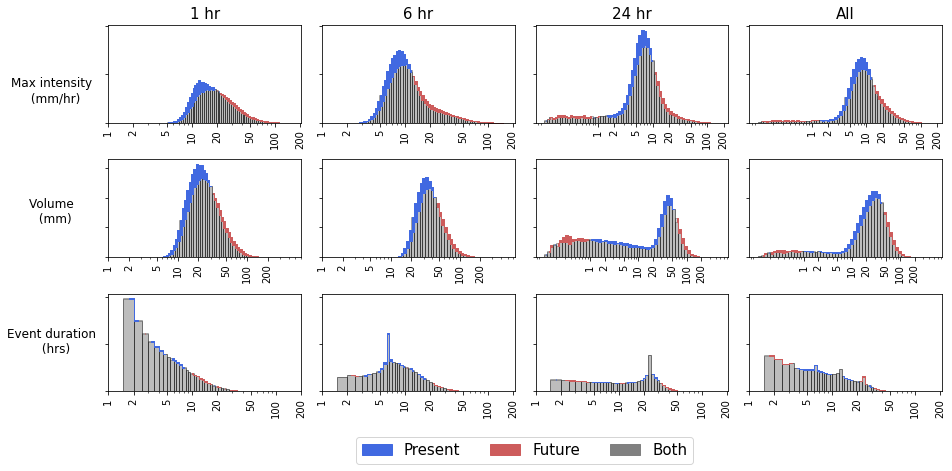

In [13]:
bin_edges_intensity = np.arange(0, 70 + 5, 2)
bin_edges_volume = np.arange(0, 135 + 5, 3)
bin_edges_duration = np.arange(0, 165 + 5,1)

durations = ['1', '6', '24']
alpha = 1
# Create a figure with subplots for different durations
n_categories = len(durations)
n_variables = 3
fig, axs = plt.subplots(n_categories, n_variables+1, figsize=(12, 2 * n_categories),  sharey='row')  

# Call the function for each variable in each duration category
for i, duration in enumerate(durations):
    plot_histogram_with_shaded_difference(present_data=present_all_events, future_data=future_all_events, variable='max_intensity', duration=duration,
    duration_variable="dur_for_which_this_is_amax", ax=axs[0,i], bins=70, alpha=alpha)
    
    plot_histogram_with_shaded_difference(present_data=present_all_events, future_data=future_all_events, variable='Volume', duration=duration,
    duration_variable="dur_for_which_this_is_amax", ax=axs[1,i], bins=60, alpha=alpha)   
    
    plot_histogram_with_shaded_difference(present_data=present_all_events, future_data=future_all_events, variable='duration', duration=duration,
    duration_variable="dur_for_which_this_is_amax", ax=axs[2,i], bins=60, alpha=alpha)       

    # Set x-axis labels for the last row
    #axs[2,0].set_xlabel("Event duration (hrs)", fontsize=10)
    #axs[2,1].set_xlabel("Event duration (hrs)", fontsize=10)
    #axs[2,2].set_xlabel("Event duration (hrs)", fontsize=10)
    #axs[2,3].set_xlabel("Event duration (hrs)", fontsize=10)    
        
    axs[0,0].set_title("1 hr", fontsize=15)
    axs[0,1].set_title("6 hr", fontsize=15)
    axs[0,2].set_title("24 hr", fontsize=15)
    axs[0,3].set_title("All", fontsize=15)
    
    # axs[0,3].legend(loc='upper right')

for ax in axs.flat:
    ax.set_yticklabels([])
    ax.set_ylabel("")

# Add the all data    
plot_histogram_with_shaded_difference_all(present_data=present_all_events, future_data=future_all_events, variable='max_intensity', 
    ax=axs[0,3], bins=70, alpha=alpha)       

plot_histogram_with_shaded_difference_all(present_data=present_all_events, future_data=future_all_events, variable='Volume', 
     ax=axs[1,3], bins=60, alpha=alpha)       

plot_histogram_with_shaded_difference_all(present_data=present_all_events, future_data=future_all_events, variable='duration', 
     ax=axs[2,3], bins=60, alpha=alpha)       

## Add legend
present_patch = mpatches.Patch(color='royalblue', label='Present')
future_patch = mpatches.Patch(color='indianred', label='Future')
both_patch = mpatches.Patch(color='grey', label='Both')
fig.legend(handles=[present_patch, future_patch, both_patch], loc = 'lower center', bbox_to_anchor=[0.5, -0.1],
           fontsize=15, ncol=4);

fig.text(-0.045, 0.78, 'Max intensity \n (mm/hr)', va='center', ha='center', fontsize=12, rotation='horizontal')
fig.text(-0.045, 0.50, 'Volume \n (mm)', va='center', ha='center', fontsize=12, rotation='horizontal')
fig.text(-0.045, 0.20, 'Event duration \n (hrs)', va='center', ha='center', fontsize=12, rotation='horizontal');

# Adjust layout to prevent overlap
plt.tight_layout()

# Seasonality of events
## Compare seasonal distribution for different durations AND between present and future

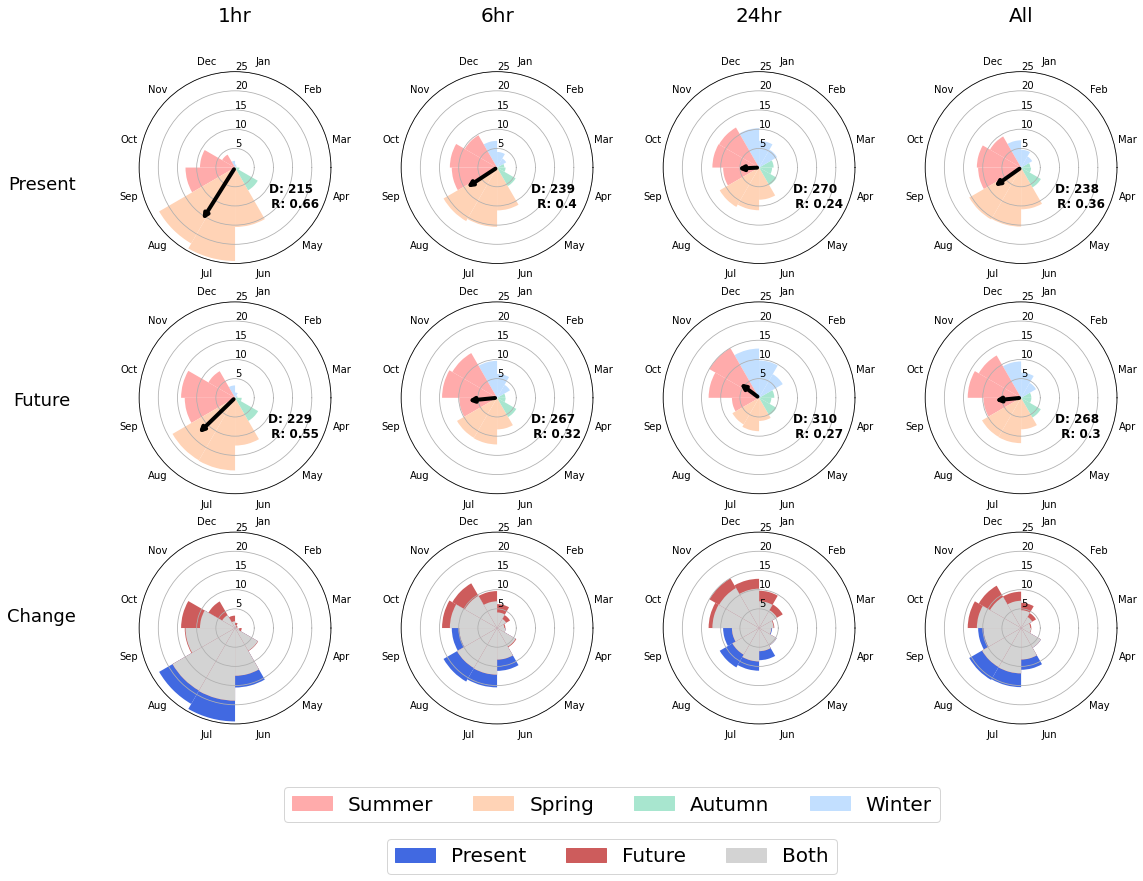

In [14]:
# List of durations and corresponding subplot titles
durations = ['1',  '6', "24"] # ['0.5', '1', '2', '3', '6',"12", '24']
titles = [f"{i}hr" for i in durations]

##########################################################
## present
##########################################################
fig, axes = plt.subplots(3, 4, figsize=(18, 12), subplot_kw={'polar': True})

# Loop through durations, axes, and titles
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = present_all_events[present_all_events['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    D_mean, R = calc_mean_day_and_dispersion(this_duration['theta'])
    plot_polar_months_plot(this_duration, axes[0, ax_num], True, title, 25, 'Percentage', D_mean, R)
D_mean, R = calc_mean_day_and_dispersion(present_all_events['theta'])    
plot_polar_months_plot(present_all_events, axes[0, 3], True, "All",25, 'Percentage', D_mean, R)    
fig.text(0.06, 0.75, 'Present', va='center', ha='center', fontsize=18, rotation='horizontal');

##########################################################
## Future
##########################################################
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration = future_all_events[future_all_events['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    D_mean, R = calc_mean_day_and_dispersion(this_duration['theta'])
    plot_polar_months_plot(this_duration, axes[1,ax_num], False, title, 25, 'Percentage', D_mean, R)
D_mean, R = calc_mean_day_and_dispersion(future_all_events['theta'])    
plot_polar_months_plot(future_all_events, axes[1,3], False, "Present (all)",25,  'Percentage', D_mean, R)    
fig.text(0.06, 0.50, 'Future', va='center', ha='center', fontsize=18, rotation='horizontal');

# ##########################################################
# ## Present and future overlaid
# ##########################################################
for ax_num, (duration, title) in enumerate(zip(durations, titles)):
    this_duration_pres = present_all_events[present_all_events['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    this_duration_future = future_all_events[future_all_events['dur_for_which_this_is_amax'].apply(
        lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    plot_polar_months_plot_overlay(this_duration_pres, this_duration_future, axes[2, ax_num], False, 'All', False, 25) 
plot_polar_months_plot_overlay(present_all_events, future_all_events, axes[2, 3], False, 'All', False, 25) 
fig.text(0.06, 0.25, 'Change', va='center', ha='center', fontsize=18, rotation='horizontal');

## Create legend
winter_patch = mpatches.Patch(color='#C2DFFF', label='Winter')
autumn_patch = mpatches.Patch(color='#A8E6CF', label='Autumn')
spring_patch = mpatches.Patch(color='#FFD3B6', label='Spring')
summer_patch = mpatches.Patch(color='#FFABAB', label='Summer')

fig.legend(handles=[summer_patch, spring_patch, autumn_patch, winter_patch], loc = 'lower center', bbox_to_anchor=[0.5, 0],
           fontsize=20, ncol=4);

## Create legend
present_patch = mpatches.Patch(color='royalblue', label='Present')
future_patch = mpatches.Patch(color='indianred', label='Future')
both_patch = mpatches.Patch(color='lightgrey', label='Both')
fig.legend(handles=[present_patch, future_patch, both_patch], loc = 'lower center', bbox_to_anchor=[0.5, -0.06],
           fontsize=20, ncol=4);

## Day of year and R values 
For each gauge we can calculate:  
    - The mean day of year that events occur  
    - The R value of events - a measure of how dispersed/concentrated events are within a year  

### Histogram of the days of year for 24h, before 

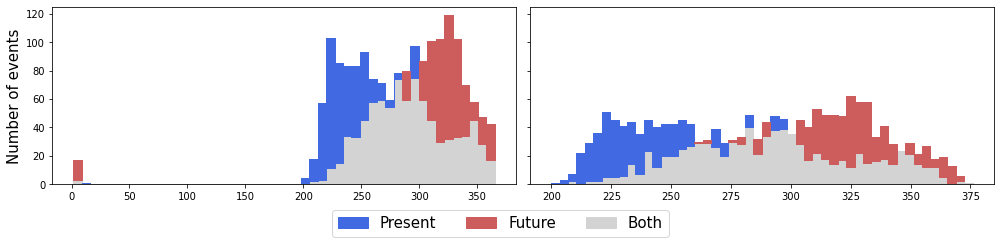

In [15]:
# Select data for a specific duration
this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(24)].copy()

fig, axs = plt.subplots(ncols=2, figsize=(14, 3), sharey=True)

bins=50
# Plot histograms for both columns with overlap regions
plot_hist_with_overlap_shading(axs[0], this_duration['D_mean_present'], this_duration['D_mean_future'], bins, color_present='RoyalBlue', color_future='IndianRed')

# Adjust for the second plot
this_duration["D_mean_present"] = this_duration["D_mean_present"].apply(lambda x: x + 365 if x < 50 else x)
this_duration["D_mean_future"] = this_duration["D_mean_future"].apply(lambda x: x + 365 if x < 50 else x)

plot_hist_with_overlap_shading(axs[1], this_duration['D_mean_present'], this_duration['D_mean_future'], bins, color_present='RoyalBlue', color_future='IndianRed')
axs[0].set_ylabel('Number of events', fontsize=15)

## Add legend
present_patch = mpatches.Patch(color='royalblue', label='Present')
future_patch = mpatches.Patch(color='indianred', label='Future')
both_patch = mpatches.Patch(color='lightgrey', label='Both')
fig.legend(handles=[present_patch, future_patch, both_patch], loc = 'lower center', bbox_to_anchor=[0.5, -0.15],
           fontsize=15, ncol=4);

plt.tight_layout()

### Day of year - present, future, change

In [16]:
# D_diffs, D_diffs_dict = find_significance_of_differences(present_all_events, future_all_events, 'D')

In [17]:
D50_diffs, D50_diffs_dict =find_significance_of_differences(present_all_events, future_all_events, 'D50_new')
# R_diffs, R_diffs_dict = find_significance_of_differences(present, future, 'R')

In [18]:
# b2_diffs, b2_diffs_dict =find_significance_of_differences(present, future, 'B2_percentage')

In [19]:
df_changes_all['D_mean_future'].min()

210.3598342107192

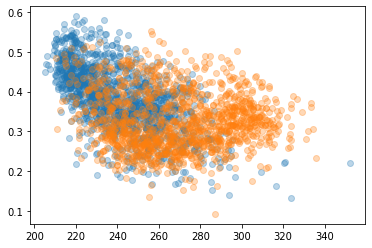

In [20]:
plt.scatter(df_changes_all['D_mean_present'],df_changes_all['R_present'], alpha=0.3)
plt.scatter(df_changes_all['D_mean_future'],df_changes_all['R_future'], alpha=0.3)

In [21]:
# fig, axs = plt.subplots(ncols=2, figsize=(8,5), sharey=True, sharex=True)
# axs[0].scatter(df_changes_all['D_mean_present'],df_changes_all['R_present'])
# axs[1].scatter(df_changes_all['D_mean_future'],df_changes_all['R_future'])

In [22]:
# df_changes_all = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_allevents_new.csv")
df_changes_all = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_allevents.csv")

df_changes_byduration_new = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_bydur_new.csv")
df_changes_byduration = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_bydur.csv")

In [23]:
this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(24)].copy()
this_duration_new = df_changes_byduration_new[df_changes_byduration_new['sampling_duration'] == float(24)].copy()

In [24]:
def make_plot_D(df_changes_all, df_changes_byduration, variable, cmap, diffs_dict, low_lim=None, high_lim=None):
    
    df_changes_all = df_changes_all.copy()
    df_changes_byduration = df_changes_byduration.copy()
    
    df_changes_all['sig'] = diffs_dict['All']
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 13))

    #################################################
    # Shift January Days in Both Present and Future
    #################################################
    variable_present = f'{variable}_present'
    variable_future = f'{variable}_future'
    
    # Apply the transformation to both present and future values
    df_changes_all[variable_present] = df_changes_all[variable_present].apply(lambda x: x + 365 if x < 80 else x)
    df_changes_all[variable_future] = df_changes_all[variable_future].apply(lambda x: x + 365 if x < 80 else x)
    
    df_changes_byduration[variable_present] = df_changes_byduration[variable_present].apply(lambda x: x + 365 if x < 80 else x)
    df_changes_byduration[variable_future] = df_changes_byduration[variable_future].apply(lambda x: x + 365 if x < 80 else x)

    #################################################
    # Determine Color Limits Based on Both Datasets
    #################################################
    if high_lim is None:
        low_lim = min(df_changes_all[variable_present].min(), df_changes_all[variable_present].min(), 
                      df_changes_byduration[variable_future].min(), df_changes_byduration[variable_future].min())

        high_lim = max(df_changes_all[variable_present].max(), df_changes_all[variable_present].max(), 
                      df_changes_byduration[variable_future].max(), df_changes_byduration[variable_future].max())   
    print(high_lim, low_lim)   

    #################################################
    # Plot Present Data for Each Duration
    #################################################
    # Using the adjusted `low_lim` and `high_lim`
    for i, duration in enumerate([1, 6, 24]):
        this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(duration)][['gauge_num', variable_present]]
        plot_values_on_map(axes[0, i], this_duration, f'{duration}h', tbo_vals, variable_present, low_lim, high_lim, cmap)

    # Plot 'All' present values
    scatter = plot_values_on_map(axes[0, 3], df_changes_all[['gauge_num', variable_present, 'sig']], 'All', tbo_vals, variable_present, low_lim, high_lim, cmap)

    cbar_ax = fig.add_axes([1.005, 0.685, 0.01, 0.26])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
    # cbar.set_label('Day of year', fontsize=15)
    
    # Use FuncFormatter to apply the custom date format to the colorbar
    ticks = np.linspace(low_lim, high_lim, num=6)  # Define ticks, covering both normal days and over 365
    cbar.set_ticks(ticks)  # Set ticks for the colorbar
    cbar.ax.tick_params(labelsize=16) 
    cbar.set_ticklabels([day_to_date(day) for day in ticks])  # Apply custom date formatting
    
#     cbar.set_ticks(np.linspace(190, 365, num=6))  # Set specific ticks
#     cbar.set_ticklabels([day_to_date(day) for day in np.linspace(190, 365, num=6)])  # Apply formatting    
    
    #################################################
    # Plot Future Data for Each Duration
    #################################################
    for i, duration in enumerate([1, 6, 24]):
        this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(duration)][['gauge_num', variable_future]]
        plot_values_on_map(axes[1, i], this_duration, f'{duration}h', tbo_vals, variable_future, low_lim, high_lim, cmap)

    # Plot 'All' future values
    scatter = plot_values_on_map(axes[1, 3], df_changes_all[['gauge_num', variable_future]], 'All', tbo_vals, variable_future, low_lim, high_lim, cmap)
    
    cbar_ax = fig.add_axes([1.005, 0.368, 0.01, 0.26])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
    # cbar.set_label('Day of year', fontsize=15)
    
    # Use FuncFormatter to apply the custom date format to the colorbar
    ticks = np.linspace(low_lim,high_lim, num=6)  # Define ticks, covering both normal days and over 365
    cbar.set_ticks(ticks)  # Set ticks for the colorbar
    cbar.ax.tick_params(labelsize=16) 
    cbar.set_ticklabels([day_to_date(day) for day in ticks])  # Apply custom date formatting
    
    #################################################
    # Plot Difference Data if Available
    #################################################
    # Apply the transformation to both present and future values
    df_changes_all['D_mean_present'] = df_changes_all['D_mean_present'].apply(lambda x: x + 365 if x < 50 else x)
    df_changes_all['D_mean_future'] = df_changes_all['D_mean_future'].apply(lambda x: x + 365 if x < 50 else x)
    df_changes_all['D_mean_diff'] = df_changes_all['D_mean_future'] - df_changes_all['D_mean_present']   
    
    df_changes_byduration['D_mean_present'] = df_changes_byduration['D_mean_present'].apply(lambda x: x + 365 if x < 50 else x)
    df_changes_byduration['D_mean_future'] = df_changes_byduration['D_mean_future'].apply(lambda x: x + 365 if x < 50 else x)
    df_changes_byduration['D_mean_diff'] = df_changes_byduration['D_mean_future'] - df_changes_byduration['D_mean_present']   
    
    # Color map setup for difference plot
    colors = [(0, "blue"), (0.35, "lightblue"), (0.5, "white"), (0.7, "lightcoral"), (1, "red")]
    cmap_diff = LinearSegmentedColormap.from_list("custom_cmap", colors)    

    variable_diff = f'{variable}_diff'

    # Calculate and apply color limits centered around 0 for the difference
    low_lim_diff = -max(abs(df_changes_all[variable_diff].min()), abs(df_changes_all[variable_diff].max()),
                        abs(df_changes_byduration[variable_diff].min()), abs(df_changes_byduration[variable_diff].max()))
    low_lim_diff = -80
    high_lim_diff = -low_lim_diff

    # Plot Difference Data if Available
    for i, duration in enumerate([1, 6, 24]):
        this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(duration)][['gauge_num', f'{variable}_diff']]
        this_duration[f'{variable}_diff'] = this_duration[f'{variable}_diff'].clip(lower=-80, upper=80)
        this_duration['sig'] =diffs_dict[duration] 
        scatter = plot_values_on_map_withsig(axes[2, i], this_duration, f'{duration}h', tbo_vals, f'{variable}_diff', low_lim_diff, high_lim_diff, cmap_diff)

    # Plot 'All' differences
    scatter = plot_values_on_map_withsig(axes[2, 3], df_changes_all[['gauge_num', variable_diff, 'sig']], 'All', tbo_vals, variable_diff, low_lim_diff, high_lim_diff, 'bwr')

    # Create the colorbar in this new axis
    cbar_ax = fig.add_axes([1.007, 0.054, 0.01, 0.26])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='vertical')
    #cbar.set_label('Difference', fontsize=15)
    cbar.ax.tick_params(labelsize=16) 

    fig.text(-0.035, 0.82, 'Present', va='center', ha='center', fontsize=17, rotation='horizontal')
    fig.text(-0.035, 0.48, 'Future', va='center', ha='center', fontsize=17, rotation='horizontal')
    fig.text(-0.035, 0.18, 'Change', va='center', ha='center', fontsize=17, rotation='horizontal')

    plt.subplots_adjust(hspace=-0.05)
    
    plt.tight_layout()


In [25]:
make_plot_D(df_changes_all, df_changes_byduration, 'D_mean','Blues', D_diffs_dict )

NameError: name 'D_diffs_dict' is not defined

In [ ]:
# # Define the colors and labels
# colors = [
#     "#00adc9",   # January
#     "#00a987",    # February
#     "#02ae4c",    # March
#     "#f6ec08",    # April
#     "#fec20c",    # May
#     "#f46c21",    # June
#     "#ef154a",    # July
#     "#ef0c6a",    # August
#     "#e00882",    # September
#     "#323294",    # October
#     "#0166b5",    # November
#     "#0099df"     # December
# ]
# month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# # Call the function to plot the circular colorbar
# plot_circular_colorbar(colors, month_labels)

In [ ]:
make_plot_D_seasonal(df_changes_all, df_changes_byduration, 'D_mean', D_diffs_dict )

###  R (how dispersed events are) - present, future change

In [ ]:
# make_plot(df_changes_all, df_changes_byduration, 'R', 'inferno')

# Loading analysis

In [ ]:
# make_plot(df_changes_all, df_changes_byduration, 'D50_P90', 'RdYlGn') # PiYG #PuBuGn
# make_plot(df_changes_all, df_changes_byduration, 'D50_P10', 'RdYlGn_R') # PiYG #PuBuGn

In [ ]:
make_plot(df_changes_all, df_changes_byduration, 'D50_mean', 'RdYlGn', D50_diffs_dict, 45, 55) 

In [ ]:
duration=24
this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'].apply(
    lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
plt.hist(df_changes_byduration['F2_percentage_diff'], bins=50, density=True)

duration=1
this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'].apply(
    lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]

plt.hist(df_changes_byduration['C_percentage_diff'], bins=50, density=True)



In [ ]:
df_changes_byduration.sort_values(by='F2_percentage_diff', ascending=False)

In [ ]:
make_plot(df_changes_all, df_changes_byduration, 'B2_percentage', 'Reds', D50_diffs_dict, 5, 25) 

## Distribution of values

In [ ]:
plt.scatter(present_all_events['D50_new'], present_all_events['max_intensity'])

In [ ]:
# Example usage with sample data
fig, axs = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)

# Example bins
bins = 5

# Plot D50 histogram with overlap
plot_quintile_hist_with_overlap_shading(axs[1], present_all_events['D50_new'], future_all_events['D50_new'], bins=bins)
axs[1].set_xlabel("$D_{50}$", fontsize=15)
axs[0].set_ylabel('Proportion of events', fontsize=15)

# Repeat for max_quintile_molly
plot_quintile_hist_with_overlap_shading(axs[0], present_all_events['max_quintile_molly'], future_all_events['max_quintile_molly'], bins=bins)
axs[0].set_xlabel('Quintile classification', fontsize=15)

# Create custom legend
present_patch = mpatches.Patch(color='royalblue', label='Present')
future_patch = mpatches.Patch(color='indianred', label='Future')
overlap_patch = mpatches.Patch(color='lightgrey', label='Overlap')
fig.legend(handles=[present_patch, future_patch, overlap_patch], loc='lower center', fontsize=14, ncol=3, bbox_to_anchor=[0.5, -0.15])

# Calculate bin edges and centers for x-tick positioning
counts, bin_edges = np.histogram(present_all_events['max_quintile_molly'], bins=5)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
axs[0].set_xticks(bin_centers)
axs[0].set_xticklabels(['F2', 'F1', 'C', 'B1', 'B2'])

plt.tight_layout()
plt.show()


In [80]:
def create_single_variable_mosaic_plot_pctlabels(ax, data, split_variable, order, color_mapping, title):
           
    # Count the occurrences and reshape for mosaic plot
    count_data = data[split_variable].value_counts().reindex(order, fill_value=0)
    # Convert to dictionary format suitable for mosaic plot
    mosaic_data = count_data.to_dict()
    
    # Function to specify properties including colors based on cross_variable
    def props(key):
        # Extract category from key if it's a tuple
        if isinstance(key, tuple):
            category = key[0]  # Extract the first element from the tuple
        else:
            category = key  # Use directly if it's not a tuple
        color = color_mapping.get(category, (0.0, 0.0, 0.0, 0.6))  # Default to black if not found
        return {'color': color}
    
    # Calculate total number of occurrences for percentage calculation
    total_count = count_data.sum()
    
    # Plot the mosaic plot with automatic labels
    labelizer = lambda key: ''
    fig, rects = mosaic(mosaic_data, title='', labelizer = labelizer, properties=props, ax=ax, gap=0.015, horizontal=True)
    ax.invert_yaxis()  # Optional: Invert y-axis to match standard bar plot orientation
    ax.set_xticklabels([])  # Remove x-axis labels
    
    the_ls = range(0,len(order))
    if split_variable == 'Loading_profile_molly': 
        the_ls = [the_ls[0]] + [x * 6 for x in the_ls[1:]]
    if split_variable == 'loading_profile_d50': 
        the_ls = [the_ls[0]] + [x * 6 for x in the_ls[1:]]

    # Manually replace the labels with percentage labels
    counter=0
    for key, (x1, y1, x2, y2) in rects.items():
        count = mosaic_data[key[0]]
        percentage = (count / total_count) * 100
        label = f'{percentage:.1f}%'
        
        # Find the label at this position and replace its text
        for text in ax.texts:
            if counter in the_ls:
                text.set_text(label)
                text.set_fontsize(17)
                text.set_color('black')
            counter=counter+1
            
    for key, (x1, y1, x2, y2) in rects.items():
        if x1 == 0:  # Check if this is the leftmost bar
            ax.text(x1-0.01, (y1 + y2) / 2, title, va='center', ha='right', fontsize=15, color='black', weight='bold')     

In [ ]:
# duration = 1
# this_duration_present = present_all_events[present_all_events['dur_for_which_this_is_amax'].apply(
#     lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
# this_duration_present = present_all_events.copy()
# # this_duration_present =this_duration_present[this_duration_present['duration']<4]
# this_duration_present['duration'].min()

62.0
48.1
52.4


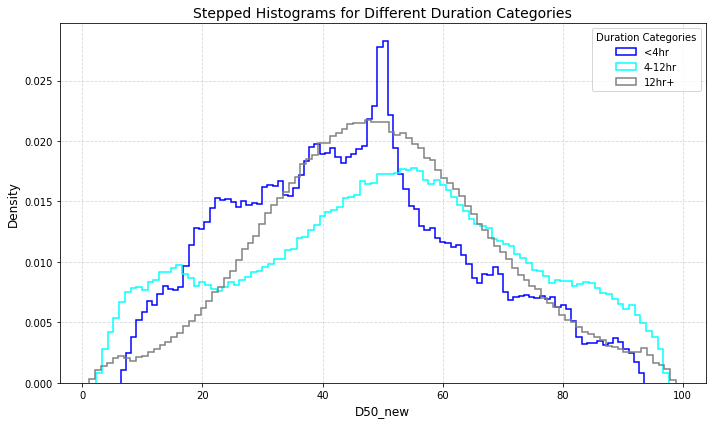

In [38]:
# Define the duration categories
durations =['<4hr', '4-12hr','12hr+']

# Colors for the different histograms
colors = ['blue', 'cyan', 'gray', 'red']

# Create a figure and axis
plt.figure(figsize=(10, 6))  # Adjust figure size

# Loop through each duration category
for ax_num, (duration, color) in enumerate(zip(durations, colors)):
    # Filter the data for this duration
    this_duration_present = present_all_events[present_all_events["DurationRange_simple"] == duration]
    less_than_50 = this_duration_present[this_duration_present['D50_new']<50]
    prop_less_than_50 = round(len(less_than_50)/len(this_duration_present) *100,1)
    print(prop_less_than_50)
    # Plot the histogram as a stepped line
    plt.hist(
        this_duration_present['D50_new'], 
        bins=100, 
        density=True, 
        histtype='step', 
        color=color, 
        linewidth=1.5, 
        label=duration
    )

# Add legend, labels, and grid
plt.xlabel('D50_new', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Stepped Histograms for Different Duration Categories', fontsize=14)
plt.legend(title='Duration Categories')
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()


60.1
47.4
50.5
54.3


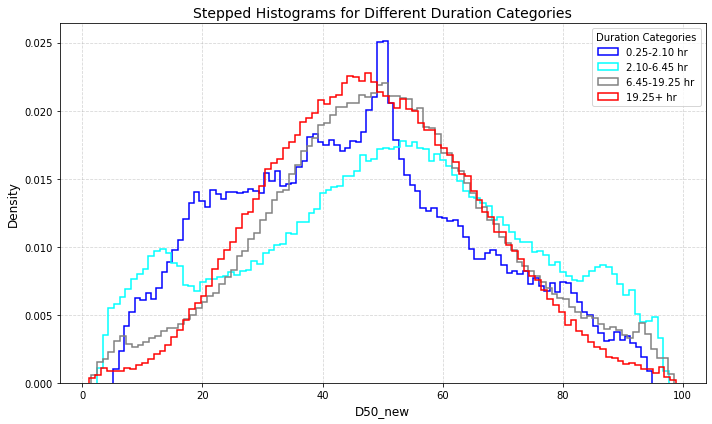

In [39]:
# Define the duration categories
durations = ['0.25-2.10 hr', '2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr']

# Colors for the different histograms
colors = ['blue', 'cyan', 'gray', 'red']

# Create a figure and axis
plt.figure(figsize=(10, 6))  # Adjust figure size

# Loop through each duration category
for ax_num, (duration, color) in enumerate(zip(durations, colors)):
    # Filter the data for this duration
    this_duration_present = present_all_events[present_all_events["DurationRange_personalised_allems"] == duration]
    less_than_50 = this_duration_present[this_duration_present['D50_new']<50]
    prop_less_than_50 = round(len(less_than_50)/len(this_duration_present) *100,1)
    print(prop_less_than_50)
    # Plot the histogram as a stepped line
    plt.hist(
        this_duration_present['D50_new'], 
        bins=100, 
        density=True, 
        histtype='step', 
        color=color, 
        linewidth=1.5, 
        label=duration
    )

# Add legend, labels, and grid
plt.xlabel('D50_new', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Stepped Histograms for Different Duration Categories', fontsize=14)
plt.legend(title='Duration Categories')
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.tight_layout()
plt.show()


0.25-2.10 hr
45.449300558938816
2.10-6.45 hr
50.49055397371761
6.45-19.25 hr
50.108877754916435
19.25+ hr
48.60652485997462
0.25-2.10 hr
46.4728016399103
2.10-6.45 hr
51.146992572282834
6.45-19.25 hr
50.606609383755234
19.25+ hr
48.21650698808668


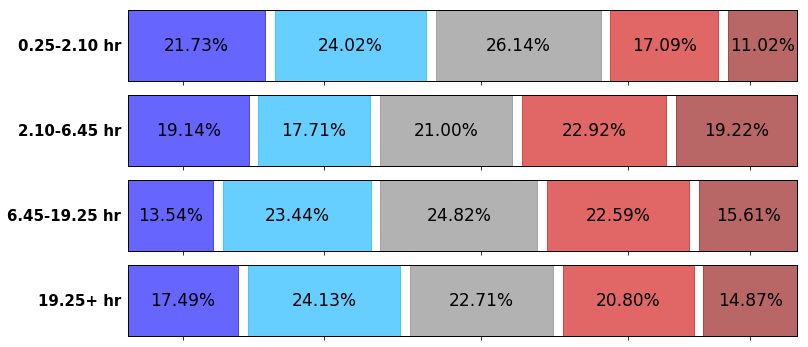

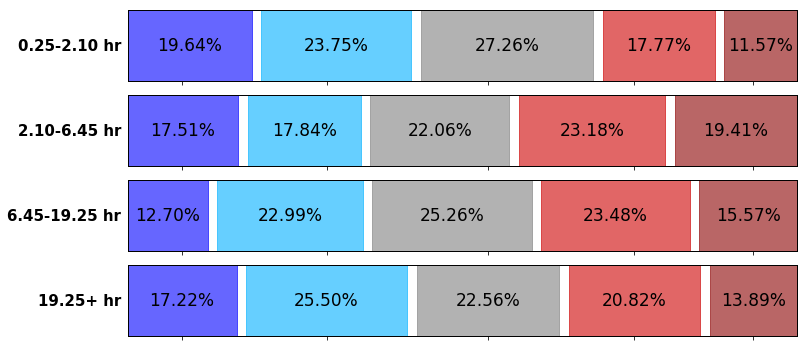

In [86]:
quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
quintile_mapping_thirds = {1: 'F', 2: 'C', 3: 'B'}
quintile_cats = ['F2','F1', 'C', 'B1', 'B2']
color_mapping = {'F2': (0.0, 0.0, 1.0, 0.6),   'F1': (0.0, 0.6902, 1.0, 0.6),
    'C': (0.5, 0.5, 0.5, 0.6), 'B1': (0.8039, 0.0, 0.0, 0.6),'B2': (0.5451, 0.0, 0.0, 0.6)} 

fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(12, 6), sharey=True, sharex='col')

for ax_num, duration in enumerate(['0.25-2.10 hr','2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr']):
    print(duration)
    this_duration_present = present_all_events[present_all_events["DurationRange_personalised_allems"] == duration]
    print(this_duration_present['D50_new'].mean())
    create_single_variable_mosaic_plot_pctlabels(axs[ax_num], this_duration_present, 'Loading_profile_molly', 
        quintile_cats, color_mapping,  duration)

fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(12, 6), sharey=True, sharex='col')

for ax_num, duration in enumerate(['0.25-2.10 hr','2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr']):
    print(duration)
    this_duration_future = future_all_events[future_all_events["DurationRange_personalised_allems"] == duration]
    print(this_duration_future['D50_new'].mean())
    create_single_variable_mosaic_plot_pctlabels(axs[ax_num], this_duration_future, 'Loading_profile_molly', 
        quintile_cats, color_mapping,  duration)
    

In [67]:
def categorize_d50(value):
    if 0 <= value < 20:
        return 'F2'
    elif 20 <= value < 40:
        return 'F1'
    elif 40 <= value < 60:
        return 'C'
    elif 60 <= value < 80:
        return 'B1'
    elif 80 <= value <= 100:
        return 'B2'
    else:
        return None  # For any values outside the specified range

# Apply the categorization function to create the new column
present_all_events['loading_profile_d50'] = present_all_events['D50_new'].apply(categorize_d50)
future_all_events['loading_profile_d50'] = future_all_events['D50_new'].apply(categorize_d50)

0.25-2.10 hr
45.449300558938816
2.10-6.45 hr
50.49055397371761
6.45-19.25 hr
50.108877754916435
19.25+ hr
48.60652485997462
0.25-2.10 hr
46.4728016399103
2.10-6.45 hr
51.146992572282834
6.45-19.25 hr
50.606609383755234
19.25+ hr
48.21650698808668


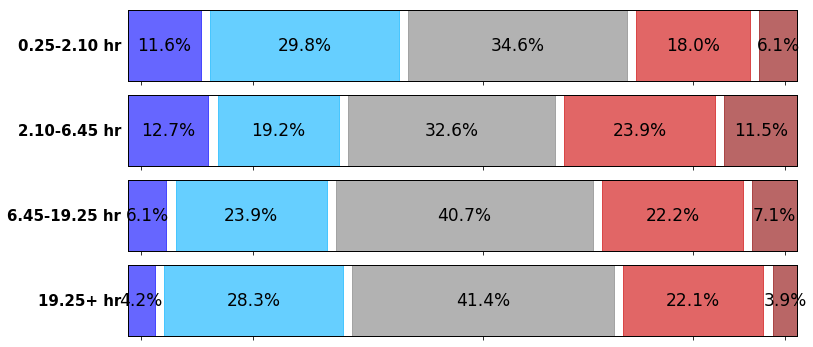

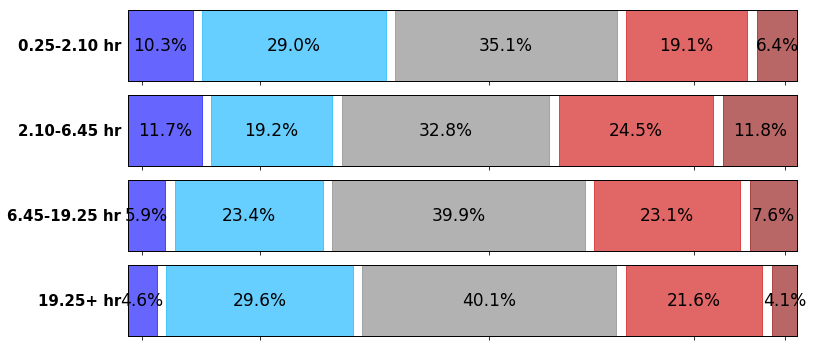

In [81]:
quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
quintile_mapping_thirds = {1: 'F', 2: 'C', 3: 'B'}
quintile_cats = ['F2','F1', 'C', 'B1', 'B2']
color_mapping = {'F2': (0.0, 0.0, 1.0, 0.6),   'F1': (0.0, 0.6902, 1.0, 0.6),
    'C': (0.5, 0.5, 0.5, 0.6), 'B1': (0.8039, 0.0, 0.0, 0.6),'B2': (0.5451, 0.0, 0.0, 0.6)} 

fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(12, 6), sharey=True, sharex='col')

for ax_num, duration in enumerate(['0.25-2.10 hr','2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr']):
    print(duration)
    this_duration_present = present_all_events[present_all_events["DurationRange_personalised_allems"] == duration]
    print(this_duration_present['D50_new'].mean())
    create_single_variable_mosaic_plot_pctlabels(axs[ax_num], this_duration_present, 'loading_profile_d50', 
        quintile_cats, color_mapping,  duration)

fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(12, 6), sharey=True, sharex='col')

for ax_num, duration in enumerate(['0.25-2.10 hr','2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr']):
    print(duration)
    this_duration_future = future_all_events[future_all_events["DurationRange_personalised_allems"] == duration]
    print(this_duration_future['D50_new'].mean())
    create_single_variable_mosaic_plot_pctlabels(axs[ax_num], this_duration_future, 'loading_profile_d50', 
        quintile_cats, color_mapping,  duration)
    

1
48.13745397134121
6
48.766825109669604
24
48.48058508980556
All
48.83864192917485
1
49.03310302265154
6
49.25559115835564
24
48.700970994101176
All
49.30281127351757


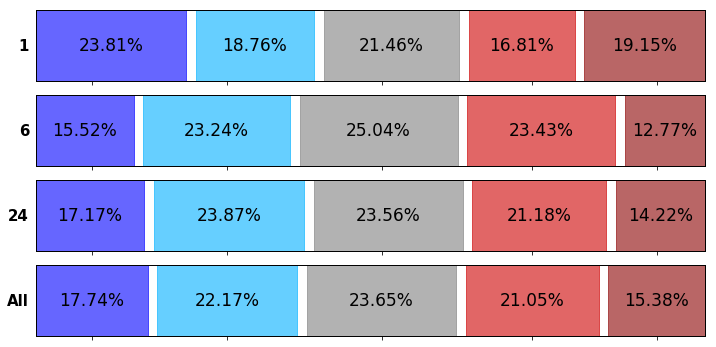

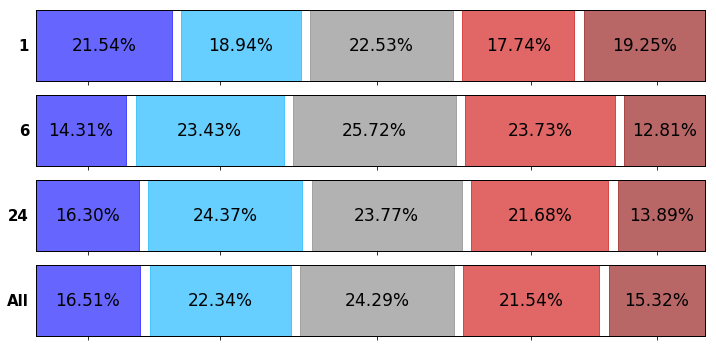

In [65]:
quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
quintile_mapping_thirds = {1: 'F', 2: 'C', 3: 'B'}
quintile_cats = ['F2','F1', 'C', 'B1', 'B2']
color_mapping = {'F2': (0.0, 0.0, 1.0, 0.6),   'F1': (0.0, 0.6902, 1.0, 0.6),
    'C': (0.5, 0.5, 0.5, 0.6), 'B1': (0.8039, 0.0, 0.0, 0.6),'B2': (0.5451, 0.0, 0.0, 0.6)} 

fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(12, 6), sharey=True, sharex='col')

for ax_num, duration in enumerate([1,6,24, 'All']):
    
    if duration =='All':
        this_duration_present = present_all_events
    else:

        this_duration_present = present_all_events[present_all_events['dur_for_which_this_is_amax'].apply(
            lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
        #this_duration_present =this_duration_present[this_duration_present['duration']<4]
    print(duration)
    print(this_duration_present['D50_new'].mean())  
    create_single_variable_mosaic_plot_pctlabels(axs[ax_num], this_duration_present, 'Loading_profile_molly', 
        quintile_cats, color_mapping,  duration)

fig, axs = plt.subplots(ncols=1, nrows=4, figsize=(12, 6), sharey=True, sharex='col')

for ax_num, duration in enumerate([1,6,24, 'All']):
    
    if duration =='All':
        this_duration_future = future_all_events
    else:
        this_duration_future = future_all_events[future_all_events['dur_for_which_this_is_amax'].apply(
            lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
    #this_duration_future =this_duration_future[this_duration_future['duration']<4]
    print(duration)
    print(this_duration_future['D50_new'].mean())      
    create_single_variable_mosaic_plot_pctlabels(axs[ax_num], this_duration_future, 'Loading_profile_molly', 
        quintile_cats, color_mapping,  duration)
    

In [ ]:
# Example usage with sample data
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(12, 10), sharey=True, sharex='col')

# Example bins
bins = 5

for ax_num, duration in enumerate([1,6,24, 'All']):
    
    if duration =='All':
        this_duration_present = present_all_events
        this_duration_future = future_all_events
    else:

        this_duration_present = present_all_events[present_all_events['dur_for_which_this_is_amax'].apply(
            lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]
        this_duration_future = future_all_events[future_all_events['dur_for_which_this_is_amax'].apply(
            lambda x: isinstance(x, list) and str(duration) in x or x == str(duration))]

    # Plot D50 histogram with overlap
    plot_quintile_hist_with_overlap_shading(axs[ax_num, 1], this_duration_present['D50_new'], this_duration_future['D50_new'], bins=bins)
    axs[3,1].set_xlabel("$D_{50}$", fontsize=15)
    axs[ax_num, 0].set_ylabel('Proportion of events', fontsize=15)

    # Repeat for max_quintile_molly
    plot_quintile_hist_with_overlap_shading(axs[ax_num, 0], this_duration_present['max_quintile_molly'], this_duration_future['max_quintile_molly'], bins=bins)
    axs[3,0].set_xlabel('Quintile classification', fontsize=15)

    # Create custom legend
    present_patch = mpatches.Patch(color='royalblue', label='Present')
    future_patch = mpatches.Patch(color='indianred', label='Future')
    overlap_patch = mpatches.Patch(color='lightgrey', label='Overlap')
    fig.legend(handles=[present_patch, future_patch, overlap_patch], loc='lower center', fontsize=14, ncol=3, bbox_to_anchor=[0.5, -0.05])

    # Calculate bin edges and centers for x-tick positioning
    counts, bin_edges = np.histogram(this_duration_present['max_quintile_molly'], bins=5)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    axs[ax_num,0].set_xticks(bin_centers)
    axs[ax_num,0].set_xticklabels(['F2', 'F1', 'C', 'B1', 'B2'])

plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 100:.0f}%'))    
plt.tight_layout()
plt.show()



## Roberto style analysis

In [ ]:
# # Apply the function to the Age column using the apply() function
# present['D50_loading'] = present['D50'].apply(categorise_D50)
# future['D50_loading'] = future['D50'].apply(categorise_D50)

In [ ]:
# quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
# quintile_mapping_thirds = {1: 'F', 2: 'C', 3: 'B'}
# quintile_cats = ['F2','F1', 'C', 'B1', 'B2']
# color_mapping = {'F2': (0.0, 0.0, 1.0, 0.6),   'F1': (0.0, 0.6902, 1.0, 0.6),
#     'C': (0.5, 0.5, 0.5, 0.6), 'B1': (0.8039, 0.0, 0.0, 0.6),'B2': (0.5451, 0.0, 0.0, 0.6)} 

# my_dict = {'Present (UKCP18)' :present, 'Future (UKCP18)':future}
# short_ids = ['Present (UKCP18)', 'Future (UKCP18)']

# # Create the subplots
# fig, axs = plt.subplots(nrows=len(short_ids), figsize=(16, 2), sharex=True)

# # Loop over each id and create the plots
# for i, id in enumerate(short_ids):
#     create_single_variable_mosaic_plot_pctlabels(axs[i], my_dict[id], 'Loading_profile_molly', 
#         quintile_cats, color_mapping,  short_ids[i])

In [ ]:
# quintile_mapping = {1: 'F', 2: 'B'}
# quintile_cats = ['F', 'B']
# color_mapping = {'F': (0.0, 0.0, 1.0, 0.6), 'B': (0.5451, 0.0, 0.0, 0.6)}

# # Create the subplots
# fig, axs = plt.subplots(nrows=len(short_ids), figsize=(16, 2), sharex=True)

# # Loop over each id and create the plots
# for i, id in enumerate(short_ids):
#     create_single_variable_mosaic_plot_pctlabels(axs[i], my_dict[id], 'D50_loading', 
#         quintile_cats, color_mapping,  short_ids[i])

## Add version for different durations

In [ ]:
np.unique(present_all_events['max_quintile_molly'], return_counts=True)

## Comparing methods

In [ ]:
# df_long = df_long.sort_values('Loading_profile_molly')
# df_long = df_long.sort_values('Loading_profile_molly', key=lambda s: s.apply(['F2', 'F1', 'C', 'B1', 'B2'].index), ignore_index=True)

# present = present.sort_values('Loading_profile_molly', key=lambda s: s.apply(['F2', 'F1', 'C', 'B1', 'B2'].index), ignore_index=True)
# future = future.sort_values('Loading_profile_molly', key=lambda s: s.apply(['F2', 'F1', 'C', 'B1', 'B2'].index), ignore_index=True)

In [ ]:
# quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
# quintile_mapping_thirds = {1: 'F', 2: 'C', 3: 'B'}
# quintile_cats = ['F2','F1', 'C', 'B1', 'B2']
# color_mapping = {'F2': (0.0, 0.0, 1.0, 0.6),   'F1': (0.0, 0.6902, 1.0, 0.6),
#     'C': (0.5, 0.5, 0.5, 0.6), 'B1': (0.8039, 0.0, 0.0, 0.6),'B2': (0.5451, 0.0, 0.0, 0.6)} 

# fig, axs = plt.subplots(figsize=(8,4))
# plot_boxplot(df_long[['Loading_profile_molly', 'D50']], axs, color_mapping)
# plt.show()

### With seasonal split

In [ ]:
# # Define custom order for Loading_profile_molly and season
# loading_order = ['F2', 'F1', 'C', 'B1', 'B2']
# season_order = [  'Spring', 'Summer', 'Autumn','Winter',]

# # Create a mapping for custom orders
# loading_mapping = {value: index for index, value in enumerate(loading_order)}
# season_mapping = {value: index for index, value in enumerate(season_order)}

# # Add new columns to the DataFrame for sorting
# present['Loading_order'] = present['Loading_profile_molly'].map(loading_mapping)
# present['Season_order'] = present['season'].map(season_mapping)

# # Sort the DataFrame by the new order columns
# present = present.sort_values(by=['Loading_order', 'Season_order'], ignore_index=True)

# # Drop the temporary sorting columns
# present = present.drop(columns=['Loading_order', 'Season_order'])

In [ ]:
# fig, axs = plt.subplots(figsize=(12,8))
# plot_boxplot_by_season(present[['Loading_profile_molly', 'D50', 'season']], axs)

### D50 vs Tb0

In [ ]:
df_merged = pd.merge(df_changes_all, tbo_vals[['gauge_num', 'Critical_interarrival_time', 'Lon', 'Lat']], on='gauge_num', how='left')

## D50 vs Day of year

In [ ]:
# variable = 'D50_P90'
# variable = 'D50_P10'

In [ ]:
test1 = pd.read_csv("/nfs/a319/gy17m2a/PhD/Scripts/FindIndependentRainfallEvents_old/AnalyseProfiles/AMAX_Events/D_mean_present.csv")
test2 = pd.read_csv("/nfs/a319/gy17m2a/PhD/Scripts/FindIndependentRainfallEvents_old/AnalyseProfiles/AMAX_Events/D_mean_future.csv")
test3 = pd.read_csv("/nfs/a319/gy17m2a/PhD/Scripts/FindIndependentRainfallEvents_old/AnalyseProfiles/AMAX_Events/D_mean_present_bydur.csv")
test4 = pd.read_csv("/nfs/a319/gy17m2a/PhD/Scripts/FindIndependentRainfallEvents_old/AnalyseProfiles/AMAX_Events/D_mean_future_bydur.csv")

In [ ]:
df_changes_all['D_mean_present_old'] = test1['D_mean_present']
df_changes_all['D_mean_future_old'] = test2['D_mean_future']


df_changes_byduration['D_mean_present_old'] = test3['D_mean_present']
df_changes_byduration['D_mean_future_old'] = test4['D_mean_future']

In [ ]:
plt.scatter(df_changes_byduration['D_mean_present_old'] , df_changes_byduration['D_mean_present'] )
plt.xlabel('Old')
plt.ylabel('New');

In [ ]:
plt.scatter(df_changes_all['D_mean_present_old'] , df_changes_all['D_mean_present'] )

In [ ]:
fig, axs = plt.subplots(ncols=2,nrows=2, figsize=(8, 6), sharey=True)    

plot_contour(axs[1,0], df_changes_all['F2_percentage_present'], df_changes_all['D_mean_present'], 'F2 percentage', )

plot_contour(axs[0,0], df_changes_all['B2_percentage_present'], df_changes_all['D_mean_present'], 'B2 percentage', )


In [ ]:
# Creating the axes layout
fig, axes = plt.subplots(
    9, 5, 
    figsize=(16, 22), 
    sharey='all', 
    sharex='all', 
    gridspec_kw={
        'hspace': 0.05, 
        'wspace': 0.14, 
        'height_ratios': [1, 1, 1, 1, 0.4, 1, 1, 1, 1]})

for ax_row in axes:
    for ax in ax_row:
        if ax is not None:  # Ensure the axis exists
            ax.yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))

loadings =['B2', 'B1', 'C', 'F1', 'F2']

# Call the function
make_scatter_plot(df_changes_byduration.copy(), 1, "present", loadings, axes, ax_row=0)
make_scatter_plot(df_changes_byduration.copy(), 6, "present", loadings, axes, ax_row=1)
make_scatter_plot(df_changes_byduration.copy(), 24, "present", loadings, axes, ax_row=2)
make_scatter_plot(df_changes_all.copy(), 'All', "present", loadings, axes, ax_row=3)
fig.text(0.5, 0.9, 'Present', va='center', ha='center', fontsize=18, rotation='horizontal')

fig.text(0.08, 0.83, '1h', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')
fig.text(0.08, 0.75, '6h', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')
fig.text(0.08, 0.66, '24h', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')
fig.text(0.08, 0.57, 'All', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')

for ax in axes[4]:
    ax.axis("off")

make_scatter_plot(df_changes_byduration.copy(), 1, "future", loadings, axes, ax_row=5)
make_scatter_plot(df_changes_byduration.copy(), 6, "future", loadings, axes, ax_row=6)
make_scatter_plot(df_changes_byduration.copy(), 24, "future", loadings, axes, ax_row=7)
make_scatter_plot(df_changes_all.copy(), 'All', "future", loadings, axes, ax_row=8)
fig.text(0.5, 0.5, 'Future', va='center', ha='center', fontsize=18, rotation='horizontal')

fig.text(0.08, 0.44, '1h', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')
fig.text(0.08, 0.35, '6h', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')
fig.text(0.08, 0.26, '24h', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')
fig.text(0.08, 0.17, 'All', va='center', ha='center', fontsize=12, rotation='horizontal', fontweight='bold')


# After plotting, convert Julian day ticks to calendar dates
for ax in axes.flatten():
    if ax is not None:  # In case of unused subplots
        # Get the current axis limits
        x_min, x_max = ax.get_xlim()
        
        # Restrict ticks to the visible range
        ticks = ax.get_xticks()
        visible_ticks = [tick for tick in ticks if x_min <= tick <= x_max]

        # Convert the visible ticks to date labels
        tick_labels = [julian_to_date(int(tick)) for tick in visible_ticks]
        # Apply the visible ticks and corresponding labels
        ax.set_xticks(visible_ticks)  # Restrict ticks to the visible range
        ax.xaxis.set_major_formatter(FixedFormatter(tick_labels))  # Set formatted labels
        ax.tick_params(axis='x', rotation=45)  # Rotate labels for better visibility

plt.show()

In [ ]:
make_scatter_plot_one_duration(df_changes_byduration, df_changes_all, 1)
# make_contour_plot_one_duration(df_changes_byduration, df_changes_all, 6)
# make_contour_plot_one_duration(df_changes_byduration, df_changes_all, 24)
# make_contour_plot_one_duration(df_changes_byduration, df_changes_all, 'All')

In [ ]:
def make_scatter_plot_onevariable(df_changes_byduration, df_changes_all, variable, label):
    
    durations =[1,6,24]

    df_changes_all_test =df_changes_all.copy()
    df_changes_byduration_test = df_changes_byduration.copy()
    
    df_changes_all_test["D_mean_present_old"] = df_changes_all_test["D_mean_present_old"].apply(lambda x: x + 365 if x < 50 else x)
    df_changes_all_test["D_mean_future_old"] = df_changes_all_test["D_mean_future_old"].apply(lambda x: x + 365 if x < 50 else x)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey='all', sharex='all', gridspec_kw={'hspace': 0.05, 'wspace':0.14})
    
    for ax_num, (duration, title) in enumerate(zip(durations, durations )):
        this_duration = df_changes_byduration_test[df_changes_byduration_test['sampling_duration'] == float(duration)][['gauge_num', f'{variable}_present', 'D_mean_present']]
        this_duration["D_mean_present"] = this_duration["D_mean_present"].apply(lambda x: x + 365 if x < 50 else x)
        make_point_density_plot(axes[0, ax_num], this_duration["D_mean_present"], this_duration[f'{variable}_present'], title)
    make_point_density_plot(axes[0, 3], df_changes_all_test["D_mean_present_old"], df_changes_all_test[f'{variable}_present'], 'All')
    fig.text(0.04, 0.7, 'Present', va='center', ha='center', fontsize=18, rotation='horizontal');
    
    for ax_num, (duration, title) in enumerate(zip(durations, durations)):
        this_duration = df_changes_byduration_test[df_changes_byduration_test['sampling_duration'] == float(duration)][['gauge_num', f'{variable}_future', 'D_mean_future']]
        this_duration["D_mean_future"] = this_duration["D_mean_future"].apply(lambda x: x + 365 if x < 50 else x)
        make_point_density_plot(axes[1, ax_num], this_duration["D_mean_future"], this_duration[f'{variable}_future'], title)
    make_point_density_plot(axes[1, 3], df_changes_all_test["D_mean_future_old"], df_changes_all_test[f'{variable}_future'], 'All')
    fig.text(0.04, 0.3, 'Future', va='center', ha='center', fontsize=18, rotation='horizontal');   
    
    
    axes[0, 0].set_ylabel(label, fontsize=12)
    axes[1, 0].set_ylabel(label, fontsize=12)
    
    # After plotting, convert Julian day ticks to calendar dates
    for ax in axes.flatten():
        
        if ax is not None:  # In case of unused subplots
            # Get the current axis limits
            x_min, x_max = ax.get_xlim()

            # Restrict ticks to the visible range
            ticks = ax.get_xticks()
            visible_ticks = [tick for tick in ticks if x_min <= tick <= x_max]

            # Convert the visible ticks to date labels
            tick_labels = [julian_to_date(int(tick)) for tick in visible_ticks]

            # Apply the visible ticks and corresponding labels
            ax.set_xticks(visible_ticks)  # Restrict ticks to the visible range
            ax.xaxis.set_major_formatter(FixedFormatter(tick_labels))  # Set formatted labels
            ax.tick_params(axis='x', rotation=45)  # Rotate labels for better visibility

        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  # 2 decimal places

In [ ]:
make_scatter_plot_onevariable(df_changes_byduration, df_changes_all,'B2_percentage', 'B2 %') 

In [ ]:
make_scatter_plot_onevariable(df_changes_byduration, df_changes_all,'B2_percentage', 'B2 %') 

In [ ]:
make_scatter_plot_onevariable(df_changes_byduration, df_changes_all,'B1_percentage', 'F1 %')

In [ ]:
def make_contour_plot(df_changes_byduration, df_changes_all, variable):
    
    d_mean_pres = "D_mean_present"
    d_mean_fut = 'D_mean_future'
    
    durations =[1,6,24]

    df_changes_all_test =df_changes_all.copy()
    df_changes_byduration_test = df_changes_byduration.copy()
    
    df_changes_all_test[d_mean_pres] = df_changes_all_test[d_mean_pres].apply(lambda x: x + 365 if x < 50 else x)
    df_changes_all_test[d_mean_fut] = df_changes_all_test[d_mean_fut].apply(lambda x: x + 365 if x < 50 else x)
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharey=False ,sharex='all', gridspec_kw={'hspace': 0.2, 'wspace':0.14})
    # fig, axes = plt.subplots(3, 4, figsize=(16, 12), sharey=False ,sharex=False, gridspec_kw={'hspace': 0.2, 'wspace':0.14})
    
    for ax_num, (duration, title) in enumerate(zip(durations, durations)):
        this_duration = df_changes_byduration_test[df_changes_byduration_test['sampling_duration'] == float(duration)].copy()
        this_duration[d_mean_pres] = this_duration[d_mean_pres].apply(lambda x: x + 365 if x < 50 else x)
        plot_contour(fig, axes[0, ax_num], this_duration[d_mean_pres],this_duration[f'{variable}_present'], "Day of year", f"{variable[:2]} %", f"{duration}hrs" )
    plot_contour(fig, axes[0, 3], df_changes_all_test[d_mean_pres],  df_changes_all_test[f'{variable}_present'],"Day of year", f"{variable[:2]} %", "All"  )
    fig.text(0.04, 0.7, 'Present', va='center', ha='center', fontsize=18, rotation='horizontal');
    
    for ax_num, (duration, title) in enumerate(zip(durations, titles)):
        this_duration = df_changes_byduration_test[df_changes_byduration_test['sampling_duration'] == float(duration)].copy()
        this_duration[d_mean_fut] = this_duration[d_mean_fut].apply(lambda x: x + 365 if x < 50 else x)
        plot_contour(fig, axes[1, ax_num], this_duration[d_mean_fut], this_duration[f'{variable}_future'], "Day of year", f"{variable[:2]} %" , f"{duration}hrs", 'Reds')   
    plot_contour(fig, axes[1, 3], df_changes_all_test[d_mean_fut], df_changes_all_test[f'{variable}_future'],  "Day of year", f"{variable[:2]} %" ,"All" , 'Reds')
    fig.text(0.04, 0.35, 'Future', va='center', ha='center', fontsize=18, rotation='horizontal');   
    #fig.text(0.04, 0.5, 'Future', va='center', ha='center', fontsize=18, rotation='horizontal');   
    
    
#     for ax_num, (duration, title) in enumerate(zip(durations, titles)):
#         this_duration = df_changes_byduration_test[df_changes_byduration_test['sampling_duration'] == float(duration)].copy()
#         # axes[2,ax_num].scatter(this_duration['D_mean_diff'], this_duration[f'{variable}_diff'])
#         plot_contour(fig, axes[2, ax_num], this_duration['D_mean_diff'], this_duration[f'{variable}_diff'], "Day of year", f"{variable[:2]} %" , f"{duration}hrs", 'Greys')   
#     plot_contour(fig, axes[2, 3], df_changes_all_test['D_mean_diff'], df_changes_all_test[f'{variable}_diff'],  "Day of year", f"{variable[:2]} %" ,"All" , 'Greys')
#     fig.text(0.04, 0.23, 'Change', va='center', ha='center', fontsize=18, rotation='horizontal');       
    

    # After plotting, convert Julian day ticks to calendar dates
    for ax in axes.flatten()[:8]:
        if ax is not None:  # In case of unused subplots
            # Get the current axis limits
            x_min, x_max = ax.get_xlim()

            # Restrict ticks to the visible range
            ticks = ax.get_xticks()
            visible_ticks = [tick for tick in ticks if x_min <= tick <= x_max]

            # Convert the visible ticks to date labels
            tick_labels = [julian_to_date(int(tick)) for tick in visible_ticks]

            # Apply the visible ticks and corresponding labels
            ax.set_xticks(visible_ticks)  # Restrict ticks to the visible range
            ax.xaxis.set_major_formatter(FixedFormatter(tick_labels))  # Set formatted labels
            ax.tick_params(axis='x', rotation=45)  # Rotate labels for better visibility

        ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  # 2 decimal places

In [ ]:
df_changes_all['D_mean_present_old'] = test1['D_mean_present']
df_changes_all['D_mean_future_old'] = test2['D_mean_future']

df_changes_byduration['D_mean_present_old'] = test3['D_mean_present']
df_changes_byduration['D_mean_future_old'] = test4['D_mean_future']

In [ ]:
make_contour_plot(df_changes_byduration, df_changes_all,'B2_percentage')

In [ ]:
make_contour_plot(df_changes_byduration, df_changes_all,'F2_percentage')

## Plot contour plot of all events against the day of year they occurred

In [ ]:
def plot_contour_all_events(ax, data_x, data_y,cmap):
    # Create a grid for the contour plot
    x_grid = np.linspace(data_x.min(), data_x.max(), 100)
    y_grid = np.linspace(data_y.min(), data_y.max(), 100)
    X, Y = np.meshgrid(x_grid, y_grid)

    # Perform Kernel Density Estimation (KDE)
    kde = gaussian_kde([data_x, data_y])
    Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

    # Normalize the density values to be between 0 and 1
    Z_normalized = (Z - Z.min()) / (Z.max() - Z.min())

    # Create the contour plot with fixed color limits between 0 and 1
    contour = ax.contourf(X, Y, Z_normalized, levels=10, cmap=cmap, alpha=0.6, vmin=0, vmax=1)
#     cbar = fig.colorbar(contour, ax=ax)
#     cbar.set_label('Density (normalized)')

    # Calculate R^2 and p-value
    slope, intercept, r_value, p_value, std_err = linregress(data_x, data_y)
    r_squared = r_value**2

    # Set labels and title
    # ax.set_xlabel('%' if ax in [axs[1, 0], axs[1, 1]] else '')
    ax.set_ylabel("$D_{50}$",fontsize=18)
    ax.set_xlim(0,366)
#     ax.set_ylim(0,6)

In [ ]:
def plot_2d_heatmap(ax, x, y, z, cmap="Blues", xlabel="Day of Year", ylabel="$D_{50}$", colorbar_label="Value"):
    """
    Plots a 2D heatmap on the given axes.

    Parameters:
        ax: Matplotlib Axes object where the heatmap will be plotted.
        x: 1D array-like. Data for the x-axis (e.g., day of the year).
        y: 1D array-like. Data for the y-axis (e.g., $D_{50}$ values).
        z: 1D array-like. Data for the color intensity (e.g., percentages or values to represent in heatmap).
        cmap: Colormap for the heatmap.
        xlabel: Label for the x-axis.
        ylabel: Label for the y-axis.
        colorbar_label: Label for the colorbar.
    """
    # Create a grid for the heatmap
    heatmap_data, xedges, yedges = np.histogram2d(x, y, bins=[100, 100], weights=z, density=False)
    
    # Normalize the grid to remove empty spaces
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    
    # Plot heatmap
    cax = ax.imshow(
        heatmap_data.T,
        origin='lower',
        extent=extent,
        aspect='auto',
        cmap=cmap,
        interpolation='nearest',
    )
    
    # Add a colorbar
    cbar = plt.colorbar(cax, ax=ax, pad=0.01)
    cbar.set_label(colorbar_label, fontsize=14)
    
    # Set axis labels
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)


In [ ]:
fig, axs = plt.subplots(nrows = 3,  figsize=(19, 10), sharex=True, gridspec_kw={'height_ratios': [1, 3,3]})
fig.suptitle("Present", fontsize=20)
fig.subplots_adjust(top=0.94)

df = present

vals, counts = np.unique(df['D'], return_counts=True)
counts_df=pd.DataFrame({'Day':vals, 'counts':counts})
axs[0].bar(np.arange(0, len(counts_df['counts'])), counts_df['counts'], color='royalblue', linewidth=2, width=1)

# # Set labels
axs[0].set_ylabel('Events', fontsize=17);
axs[1].set_ylabel("Quintile", fontsize=17);

# Set bins to align with the y-axis discrete values
y_bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]  # Bins centered around 1, 2, 3, 4, 5
x_bins = 365  # You can keep this as a default for x-axis

# Create the 2D histogram
hist, x_edges, y_edges, _ = axs[1].hist2d(
    df['D'], 
    df['max_quintile_molly'], 
    bins=[x_bins, y_bins],  # Use custom y_bins
    cmap='Blues'
)


plot_contour_all_events(axs[2], df['D'], df['D50_new'], 'Blues')

def date_to_julian_day(date):
    """Convert a date (YYYY-MM-DD) to its Julian day of the year."""
    date = datetime.strptime(date, "%Y-%m-%d")
    return date.timetuple().tm_yday

# Define specific dates
march_1 = date_to_julian_day("2000-03-01")
june_1 = date_to_julian_day("2000-06-01")
sept_1 = date_to_julian_day("2000-09-01")
dec_1 = date_to_julian_day("2000-12-01")

# After plotting your figure, you can add a vertical line to axs[1]
axs[1].axvline(x=march_1, color='black', linestyle='--', linewidth=2, label="1st March")
axs[1].axvline(x=june_1, color='black', linestyle='--', linewidth=2, label="1st June")
axs[1].axvline(x=sept_1, color='black', linestyle='--', linewidth=2, label="1st September")
axs[1].axvline(x=dec_1, color='black', linestyle='--', linewidth=2, label="1st December")

# After plotting your figure, you can add a vertical line to axs[1]
axs[2].axvline(x=march_1, color='black', linestyle='--', linewidth=2, label="1st March")
axs[2].axvline(x=june_1, color='black', linestyle='--', linewidth=2, label="1st June")
axs[2].axvline(x=sept_1, color='black', linestyle='--', linewidth=2, label="1st September")
axs[2].axvline(x=dec_1, color='black', linestyle='--', linewidth=2, label="1st December")

# After plotting, convert Julian day ticks to calendar dates
ax = axs[1]

if ax is not None:  # In case of unused subplots
    # Get the current axis limits
    x_min, x_max = ax.get_xlim()

    # Use MaxNLocator to control the number of ticks on x-axis
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune='lower', nbins=25))  # Adjust nbins as needed

    # Restrict ticks to the visible range
    ticks = ax.get_xticks()
    visible_ticks = [tick for tick in ticks if x_min <= tick <= x_max]

    # Convert the visible ticks to date labels
    tick_labels = [julian_to_date(int(tick)) for tick in visible_ticks]

    # Apply the visible ticks and corresponding labels
    ax.set_xticks(visible_ticks)  # Set the new x-ticks
    ax.xaxis.set_major_formatter(FixedFormatter(tick_labels))  # Set formatted labels
    ax.tick_params(axis='x', rotation=90)  # Rotate labels for better visibility

# Format y-axis
# ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  # 2 decimal places

In [ ]:
fig, axs = plt.subplots(nrows = 3,  figsize=(19, 12), sharex=True, gridspec_kw={'height_ratios': [1, 3,3]})
fig.suptitle("Future", fontsize=20)
fig.subplots_adjust(top=0.94)

df = present_all_events

vals, counts = np.unique(df['D'], return_counts=True)
counts_df=pd.DataFrame({'Day':vals, 'counts':counts})
axs[0].bar(np.arange(0, len(counts_df['counts'])), counts_df['counts'], color='indianred', linewidth=2, width=1)

# Set labels
axs[1].set_ylabel("$D_{50}$", fontsize=17);
axs[0].set_ylabel('Events', fontsize=17);

# Set bins to align with the y-axis discrete values
y_bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5]  # Bins centered around 1, 2, 3, 4, 5
x_bins = 365  # You can keep this as a default for x-axis

# Create the 2D histogram
hist, x_edges, y_edges, _ = axs[1].hist2d(
    df['D'], 
    df['max_quintile_molly'], 
    bins=[x_bins, y_bins],  # Use custom y_bins
    cmap='Reds'
)

plot_contour_all_events(axs[2], df['D'], df['D50_new'], 'Reds' )

def date_to_julian_day(date):
    """Convert a date (YYYY-MM-DD) to its Julian day of the year."""
    date = datetime.strptime(date, "%Y-%m-%d")
    return date.timetuple().tm_yday

# Define specific dates
march_1 = date_to_julian_day("2000-03-01")
june_1 = date_to_julian_day("2000-06-01")
sept_1 = date_to_julian_day("2000-09-01")
dec_1 = date_to_julian_day("2000-12-01")

# After plotting your figure, you can add a vertical line to axs[1]
# After plotting your figure, you can add a vertical line to axs[1]
axs[0].axvline(x=march_1, color='black', linestyle='--', linewidth=2, label="1st March")
axs[0].axvline(x=june_1, color='black', linestyle='--', linewidth=2, label="1st June")
axs[0].axvline(x=sept_1, color='black', linestyle='--', linewidth=2, label="1st September")
axs[0].axvline(x=dec_1, color='black', linestyle='--', linewidth=2, label="1st December")

# After plotting your figure, you can add a vertical line to axs[1]
axs[1].axvline(x=march_1, color='black', linestyle='--', linewidth=2, label="1st March")
axs[1].axvline(x=june_1, color='black', linestyle='--', linewidth=2, label="1st June")
axs[1].axvline(x=sept_1, color='black', linestyle='--', linewidth=2, label="1st September")
axs[1].axvline(x=dec_1, color='black', linestyle='--', linewidth=2, label="1st December")

# After plotting your figure, you can add a vertical line to axs[1]
axs[2].axvline(x=march_1, color='black', linestyle='--', linewidth=2, label="1st March")
axs[2].axvline(x=june_1, color='black', linestyle='--', linewidth=2, label="1st June")
axs[2].axvline(x=sept_1, color='black', linestyle='--', linewidth=2, label="1st September")
axs[2].axvline(x=dec_1, color='black', linestyle='--', linewidth=2, label="1st December")

# After plotting, convert Julian day ticks to calendar dates
ax = axs[1]

if ax is not None:  # In case of unused subplots
    # Get the current axis limits
    x_min, x_max = ax.get_xlim()

    # Use MaxNLocator to control the number of ticks on x-axis
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune='lower', nbins=25))  # Adjust nbins as needed

    # Restrict ticks to the visible range
    ticks = ax.get_xticks()
    visible_ticks = [tick for tick in ticks if x_min <= tick <= x_max]

    # Convert the visible ticks to date labels
    tick_labels = [julian_to_date(int(tick)) for tick in visible_ticks]

    # Apply the visible ticks and corresponding labels
    ax.set_xticks(visible_ticks)  # Set the new x-ticks
    ax.xaxis.set_major_formatter(FixedFormatter(tick_labels))  # Set formatted labels
    ax.tick_params(axis='x', rotation=90)  # Rotate labels for better visibility

# Format y-axis
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  # 2 decimal places

In [ ]:
fig, axs = plt.subplots(nrows = 2,  figsize=(19, 8), sharex=True, gridspec_kw={'height_ratios': [1, 4]})
fig.suptitle("Future", fontsize=20)
fig.subplots_adjust(top=0.94)

# Define specific dates
march_1 = date_to_julian_day("2000-03-01")
june_1 = date_to_julian_day("2000-06-01")
sept_1 = date_to_julian_day("2000-09-01")
dec_1 = date_to_julian_day("2000-12-01")


df = future

vals, counts = np.unique(df['D'], return_counts=True)
counts_df=pd.DataFrame({'Day':vals, 'counts':counts})
axs[0].bar(np.arange(0, len(counts_df['counts'])), counts_df['counts'], color='indianred', linewidth=2, width=1)

# Set labels
axs[1].set_ylabel("$D_{50}$", fontsize=17);
axs[0].set_ylabel('Events', fontsize=17);

plot_contour_all_events(axs[1], df['D'], df['D50_new'], 'F2 percentage', 'Reds' )

def date_to_julian_day(date):
    """Convert a date (YYYY-MM-DD) to its Julian day of the year."""
    date = datetime.strptime(date, "%Y-%m-%d")
    return date.timetuple().tm_yday

# After plotting your figure, you can add a vertical line to axs[1]
axs[0].axvline(x=march_1, color='black', linestyle='--', linewidth=2, label="1st March")
axs[0].axvline(x=june_1, color='black', linestyle='--', linewidth=2, label="1st June")
axs[0].axvline(x=sept_1, color='black', linestyle='--', linewidth=2, label="1st September")
axs[0].axvline(x=dec_1, color='black', linestyle='--', linewidth=2, label="1st December")

# After plotting your figure, you can add a vertical line to axs[1]
axs[1].axvline(x=march_1, color='black', linestyle='--', linewidth=2, label="1st March")
axs[1].axvline(x=june_1, color='black', linestyle='--', linewidth=2, label="1st June")
axs[1].axvline(x=sept_1, color='black', linestyle='--', linewidth=2, label="1st September")
axs[1].axvline(x=dec_1, color='black', linestyle='--', linewidth=2, label="1st December")

# After plotting, convert Julian day ticks to calendar dates
ax = axs[1]

if ax is not None:  # In case of unused subplots
    # Get the current axis limits
    x_min, x_max = ax.get_xlim()

    # Use MaxNLocator to control the number of ticks on x-axis
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, prune='lower', nbins=50))  # Adjust nbins as needed

    # Restrict ticks to the visible range
    ticks = ax.get_xticks()
    visible_ticks = [tick for tick in ticks if x_min <= tick <= x_max]

    # Convert the visible ticks to date labels
    tick_labels = [julian_to_date(int(tick)) for tick in visible_ticks]

    # Apply the visible ticks and corresponding labels
    ax.set_xticks(visible_ticks)  # Set the new x-ticks
    ax.xaxis.set_major_formatter(FixedFormatter(tick_labels))  # Set formatted labels
    ax.tick_params(axis='x', rotation=90)  # Rotate labels for better visibility

# Format y-axis
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))  # 2 decimal places

## Another option: 